<a href="https://colab.research.google.com/github/GA239/DS_course/blob/master/HW7/tsk1/torch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import os
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F

In [52]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import time
from IPython import display
%matplotlib inline


In [53]:
torch.cuda.device_count()

1

In [54]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
DRIVE = '/content/drive/My Drive'

In [57]:
Xtrain = pd.read_csv(os.path.join(DRIVE, 'X_train.csv'), index_col=0).astype(np.float32)
Xtest = pd.read_csv(os.path.join(DRIVE, 'X_test.csv'), index_col=0).astype(np.float32)
Ytrain = pd.read_csv(os.path.join(DRIVE, 'Y_train.csv'), index_col=0).astype(np.float32)
Ytest = pd.read_csv(os.path.join(DRIVE, 'Y_test.csv'), index_col=0).astype(np.float32)

In [58]:
Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape 

((2967, 378), (742, 378), (2967, 3), (742, 3))

In [59]:
Ytrain["target"] = Ytrain['Class_compensated_hypothyroid'] * 0 + Ytrain['Class_negative'] * 1 + Ytrain['Class_primary_hypothyroid'] * 2
Ytest["target"] = Ytest['Class_compensated_hypothyroid'] * 0 + Ytest['Class_negative'] * 1 + Ytest['Class_primary_hypothyroid'] * 2

Ytrain = Ytrain.drop(columns=['Class_compensated_hypothyroid', 'Class_negative', 'Class_primary_hypothyroid']).astype(np.int)
Ytest = Ytest.drop(columns=['Class_compensated_hypothyroid', 'Class_negative', 'Class_primary_hypothyroid']).astype(np.int)

In [60]:
Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape 

((2967, 378), (742, 378), (2967, 1), (742, 1))

In [61]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(378, 3)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        return self.out_act(self.fc(input_))
    
net = Net().to(device)
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [62]:
def train_epoch(model, opt, criterion, num_steps=50):
    model.train()
    for _ in range(num_steps):
        xbatch = Xtrain.sample(400)
        ybatch = Ytrain.loc[xbatch.index]
        x_batch = Variable(torch.tensor(xbatch.values)).to(device)
        y_batch = Variable(torch.tensor(ybatch.target.values)).to(device)

        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        y_hat_valid = net(Variable(torch.tensor(Xtest.values)).to(device))
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        loss_2 = criterion(y_hat_valid, Variable(torch.tensor(Ytest.target.values).to(device)))
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
    return float(loss.data.cpu().numpy()), float(loss_2.data.cpu().numpy())

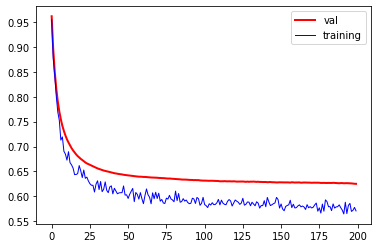

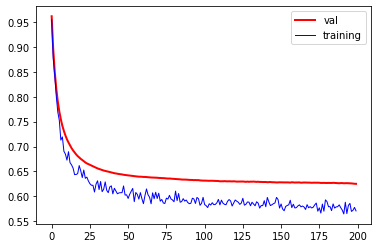

In [63]:
num_epochs = 200
losses_train = []
losses_test = []
for i in range(num_epochs):
  loss_train, loss_test = train_epoch(net, opt, criterion)
  losses_train.append(loss_train)
  losses_test.append(loss_test)
  plt.clf()
  plt.plot(losses_test, 'r-', lw=2, label='val')
  plt.plot(losses_train, 'b-', lw=1, label='training')
  plt.legend()
  display.clear_output(wait=True)
  display.display(plt.gcf())